In [1]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import random
import sys

# import gym

# env = gym.make('CartPole-v1') 
""" 
Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf
Actions:
    Type: Discrete(2)
    Num   Action
    0     Push cart to the left
    1     Push cart to the right
    Note: The amount the velocity that is reduced or increased is not
    fixed; it depends on the angle the pole is pointing. This is because
    the center of gravity of the pole increases the amount of energy needed
    to move the cart underneath it
Reward:
    Reward is 1 for every step taken, including the termination step
Starting State:
    All observations are assigned a uniform random value in [-0.05..0.05]
Episode Termination:
    Pole Angle is more than 12 degrees.
    Cart Position is more than 2.4 (center of the cart reaches the edge of
    the display).
    Episode length is greater than 200.
    Solved Requirements:
    Considered solved when the average return is greater than or equal to
    195.0 over 100 consecutive trials.
"""

X_range = [-4.8, 4.8]
v_range = [-10, 10]#[-100000, 100000] #[float('-inf'), float('inf')]
theta_range = [-24, 24]
anglev_range = [-10, 10] #[-100000, 100000]#[float('-inf'), float('inf')]
start_range = [-0.05, 0.05]

terminating_cond =[2.4, 12, 200]

action_set = [0,1] #left, right

M = 3 # dimensionality of the fourier transform
softmax_sigma = 0.1
# gamma = 1

In [2]:
def in_radian(ang):
    return ang*np.pi/180

In [3]:
def transition(action, x, x_dot, theta, theta_dot):
    gravity = 9.8
    masscart = 1.0
    masspole = 0.1
    total_mass = masspole + masscart
    length = 0.5  # actually half the pole's length
    polemass_length = masspole * length
    force_mag = 10.0
    tau = 0.02

    force = force_mag if action == 1 else -force_mag
    costheta = np.cos(theta) # theta in radians
    sintheta = np.sin(theta)

    # from gym https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
    temp = (force + polemass_length * theta_dot ** 2 * sintheta) / total_mass
    thetaacc = (gravity * sintheta - costheta * temp) / (length * (4.0 / 3.0 - masspole * costheta ** 2 / total_mass))
    xacc = temp - polemass_length * thetaacc * costheta / total_mass
    
    #euler
    x = x + tau * x_dot
    x_dot = x_dot + tau * xacc
    theta = theta + tau * theta_dot
    theta_dot = theta_dot + tau * thetaacc
    
    #semi euler
    # x_dot = x_dot + tau * xacc
    # x = x + tau * x_dot
    # theta_dot = theta_dot + tau * thetaacc
    # theta = theta + tau * theta_dot

    return x, x_dot, theta, theta_dot

In [4]:
def is_terminating(x, x_dot, theta, theta_dot, step):
    if x <= -terminating_cond[0] or x >= terminating_cond[0] or theta <= -in_radian(terminating_cond[1]) or theta >= in_radian(terminating_cond[1]) or step>=terminating_cond[2]:
        return True
    return False

In [5]:
def reward(x, x_dot, theta, theta_dot, step):
    if is_terminating(x, x_dot, theta, theta_dot, step):
        return 0
    return 1

def normalize(x, x_dot, theta, theta_dot, cosineflag=True):
    if cosineflag:
        x = (x-X_range[0])/(X_range[1]-X_range[0])
        theta = (theta-theta_range[0])/(theta_range[1]-theta_range[0])
        x_dot = (x_dot - v_range[0])/(v_range[1] - v_range[0])
        theta_dot = (theta_dot - anglev_range[0])/(anglev_range[1] - anglev_range[0])
        
    else:
        x = 2*(x-X_range[0])/(X_range[1]-X_range[0]) -1
        theta = 2*(theta-theta_range[0])/(theta_range[1]-theta_range[0]) -1
        x_dot = 2*(x_dot - v_range[0])/(v_range[1] - v_range[0]) -1
        theta_dot = 2*(theta_dot - anglev_range[0])/(anglev_range[1] - anglev_range[0]) -1

    return  x, x_dot, theta, theta_dot

In [6]:
def fourier(x, x_dot, theta, theta_dot, cosineflag=False): #4M+1 features
    #normalize
    x, x_dot, theta, theta_dot = normalize(x, x_dot, theta, theta_dot, cosineflag)
    phi = [1]
    if cosineflag:
        for i in range(1, M+1):
            phi.append(np.cos(i*np.pi*x))
        for i in range(1, M+1):
            phi.append(np.cos(i*np.pi*x_dot))
        for i in range(1, M+1):
            phi.append(np.cos(i*np.pi*theta))
        for i in range(1, M+1):
            phi.append(np.cos(i*np.pi*theta_dot))
    else:
        for i in range(1, M+1):
            phi.append(np.sin(i*np.pi*x))
        for i in range(1, M+1):
            phi.append(np.sin(i*np.pi*x_dot))
        for i in range(1, M+1):
            phi.append(np.sin(i*np.pi*theta))
        for i in range(1, M+1):
            phi.append(np.sin(i*np.pi*theta_dot))
    return np.array(phi)



In [7]:
def softmax_action(policy_params, x, x_dot, theta, theta_dot):
    
    phi_s = fourier(x, x_dot, theta, theta_dot) # (4M+1, )
    # print(policy_params.shape, phi_s.shape)
    policy_val = np.dot(phi_s.T, policy_params) #(4M,1) (4M+1, 2)
    policy_exp = np.exp(softmax_sigma*policy_val)
    policy_exp /= np.sum(policy_exp)
    # print(policy_exp, x, x_dot, theta, theta_dot)
    return policy_exp #(2, )

In [8]:
def ACTOR_CRITIC(alpha_w, alpha_theta, gamma=1.0):
    policy_params = np.random.normal(0, 0.1, (4*M+1,len(action_set))) #np.ones((4*M+1,len(action_set)))*(-0.01)
    value_params = np.ones(4*M+1)*0.01
    episode_length, avg_return = [], []

    for iter in range(4000):
        policy_params_temp = policy_params.copy()
        #run episode
        #initial state
        x = np.random.uniform(start_range[0], start_range[1])
        theta = np.random.uniform(start_range[0], start_range[1])
        x_dot  = np.random.uniform(start_range[0], start_range[1])
        theta_dot = np.random.uniform(start_range[0], start_range[1])
        step = 1
        _return = 0
        
        # #using gym
        # x, x_dot, theta, theta_dot = env.reset() 

        #run epsidoe
        while not is_terminating(x, x_dot, theta, theta_dot, step):
            #choose action
            curr_action = random.choices(action_set, softmax_action(policy_params, x, x_dot, theta, theta_dot))

            # #using gym
            # observation, curr_reward, done, info = env.step(curr_action)
            # next_x, next_x_dot, next_theta, mext_theta_dot = observation

            #next state
            next_x, next_x_dot, next_theta, mext_theta_dot = transition(curr_action, x, x_dot, theta, theta_dot)
            #reward
            curr_reward = reward(next_x, next_x_dot, next_theta, mext_theta_dot, step)
            _return += curr_reward*gamma**(step-1)
            step += 1
            print(x, x_dot, theta, theta_dot, curr_action, softmax_action(policy_params, x, x_dot, theta, theta_dot))

            phi_s = fourier(x, x_dot, theta, theta_dot)
            phi_next_s = fourier(next_x, next_x_dot, next_theta, mext_theta_dot)
            if not is_terminating(next_x, next_x_dot, next_theta, mext_theta_dot, step):
                delta = curr_reward +gamma*np.dot(phi_next_s, value_params) - np.dot(phi_s, value_params)
            else:
                delta = curr_reward - np.dot(phi_s, value_params)
            #update value params
            value_params += alpha_w*delta*phi_s
            #update policy params
            policy = softmax_action(policy_params, x, x_dot, theta, theta_dot)
            if curr_action == 0:
                policy_params[:,0] += alpha_theta*delta*(1-policy[0])*phi_s
                policy_params[:,1] += alpha_theta*delta*(-1*policy[0])*phi_s
                # print(curr_action, delta, policy)
            if curr_action == 1:
                policy_params[:,0] += alpha_theta*delta*(-policy[1])*phi_s
                policy_params[:,1] += alpha_theta*delta*(1-policy[1])*phi_s

            x, x_dot, theta, theta_dot = next_x, next_x_dot, next_theta, mext_theta_dot

        episode_length.append(step)
        avg_return.append(_return)
        
        print("\n EPISODE LENGTH: ",step, "CURR ITER: ", iter)
        if np.mean(avg_return[max(0, iter-100): iter+1]) > 195.0:
            print("Hooray... solved")
            break
        max_diff = np.max(np.abs(policy_params_temp - policy_params))
        print(" Max diff: ",max_diff)
        if max_diff/alpha_theta < 0.001: # 0.001 works with 1e-6 policy_step
            break

    plt.figure()
    plt.plot(np.arange(len(avg_return)), avg_return)
    plt.xlabel('Iterations')
    plt.ylabel('Avg. return')
    plt.savefig('graph_cartpole_actorcritic')

-0.033637792137466815 0.020173748446503076 -0.040604825879938 -0.04118724339077337 [1] [0.4966 0.5034]
-0.03323431716853675 -0.17434312350590514 -0.04142857074775347 0.23841302637755182 [1] [0.4977 0.5023]
-0.03672117963865486 -0.3688494916489249 -0.036660310220202434 0.5177457211228799 [1] [0.4988 0.5012]
-0.04409816947163336 -0.5634366095681704 -0.026305395797744838 0.7986545622090948 [0] [0.4998 0.5002]
-0.055366901662996765 -0.7581879862490619 -0.010332304553562943 1.0829476664481719 [1] [0.5007 0.4993]
-0.070530661387978 -0.9531720663087261 0.011326648775400495 1.3723705313205226 [0] [0.5015 0.4985]
-0.08959410271415252 -1.1484337995866227 0.038774059401810945 1.6685743069441825 [0] [0.5023 0.4977]
-0.11256277870588498 -1.3439844761902013 0.0721455455406946 1.9730765695210255 [0] [0.5029 0.4971]
-0.139442468229689 -1.5397892933006692 0.11160707693111512 2.2872121514816826 [1] [0.5034 0.4966]
-0.1702382540957024 -1.7357522972438075 0.15735131996074878 2.612072253556491 [0] [0.5037 

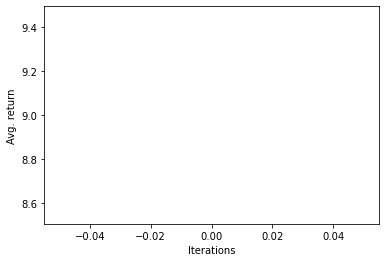

In [9]:
alpha_w, alpha_theta = 1e-7, 5e-4
ACTOR_CRITIC(alpha_w, alpha_theta)